In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import shap
import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
DATA_DIR = Path("../data/processed")
ARTIFACT_DIR = Path("../model")

bowler_df = pd.read_csv(DATA_DIR / "bowler_model_data.csv", parse_dates=["date"])
pipeline = joblib.load(ARTIFACT_DIR / "feature_pipeline_bowler.pkl")

print("Dataset shape:", bowler_df.shape)

Dataset shape: (12448, 13)


In [3]:
split_date = "2023-01-01"

train_df = bowler_df[bowler_df["date"] < split_date]
test_df  = bowler_df[bowler_df["date"] >= split_date]

target = "wickets_next_match"

drop_cols = ["match_id", "date", "bowler", target]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (10878, 9)
Test shape: (1570, 9)


In [4]:
X_train_p = pipeline.transform(X_train)
X_test_p  = pipeline.transform(X_test)

feature_names = pipeline.get_feature_names_out()

In [5]:
baseline_pred = test_df["wickets_avg_last_5"].fillna(
    test_df["wickets_avg_last_5"].mean()
)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Performance")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)
print("R2  :", baseline_r2)

Baseline Performance
MAE : 0.8936836518046709
RMSE: 1.1523953483610885
R2  : -0.14782041251114442


In [6]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=15,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train)

rf_pred = rf.predict(X_test_p)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest")
print("MAE :", rf_mae)
print("RMSE:", rf_rmse)
print("R2  :", rf_r2)

Random Forest
MAE : 0.8256999087314671
RMSE: 1.0605953576944185
R2  : 0.027766918615809377


In [7]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_p, y_train)

xgb_pred = xgb.predict(X_test_p)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost")
print("MAE :", xgb_mae)
print("RMSE:", xgb_rmse)
print("R2  :", xgb_r2)

XGBoost
MAE : 0.8478875730732444
RMSE: 1.0725592128459491
R2  : 0.005709005436038472


In [8]:
lgb = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)

lgb.fit(X_train_p, y_train)

lgb_pred = lgb.predict(X_test_p)

lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print("LightGBM")
print("MAE :", lgb_mae)
print("RMSE:", lgb_rmse)
print("R2  :", lgb_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 10878, number of used features: 74
[LightGBM] [Info] Start training from score 0.997426
LightGBM
MAE : 0.8529812060163164
RMSE: 1.0755070234747213
R2  : 0.00023609677720559663


X does not have valid feature names, but LGBMRegressor was fitted with feature names


In [9]:
param_grid = {
    "n_estimators": [300, 400],
    "max_depth": [5, 6],
    "learning_rate": [0.03, 0.05]
}

grid = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_p, y_train)

best_xgb = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300}


In [10]:
results = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "XGBoost", "LightGBM"],
    "MAE": [baseline_mae, rf_mae, xgb_mae, lgb_mae],
    "RMSE": [baseline_rmse, rf_rmse, xgb_rmse, lgb_rmse],
    "R2": [baseline_r2, rf_r2, xgb_r2, lgb_r2]
})

results.sort_values("RMSE")

,Model,MAE,RMSE,R2
1,Random Forest,0.825700,1.060595,0.027767
2,XGBoost,0.847888,1.072559,0.005709
3,LightGBM,0.852981,1.075507,0.000236
0,Baseline,0.893684,1.152395,-0.147820


In [11]:
import joblib
from pathlib import Path

ARTIFACT_DIR = Path("../model")

joblib.dump(rf, ARTIFACT_DIR / "rf_wickets_model.joblib")

print("✅ Random Forest Wicket Model Saved")

✅ Random Forest Wicket Model Saved


In [12]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Take small sample for SHAP (important)
sample_size = 2000

sample_idx = np.random.choice(
    X_train_p.shape[0],
    sample_size,
    replace=False
)

X_shap_sample = X_train_p[sample_idx]

# Convert ONLY sample to dense if sparse
if hasattr(X_shap_sample, "toarray"):
    X_shap_sample = X_shap_sample.toarray()

feature_names = pipeline.get_feature_names_out()

In [13]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_shap_sample)

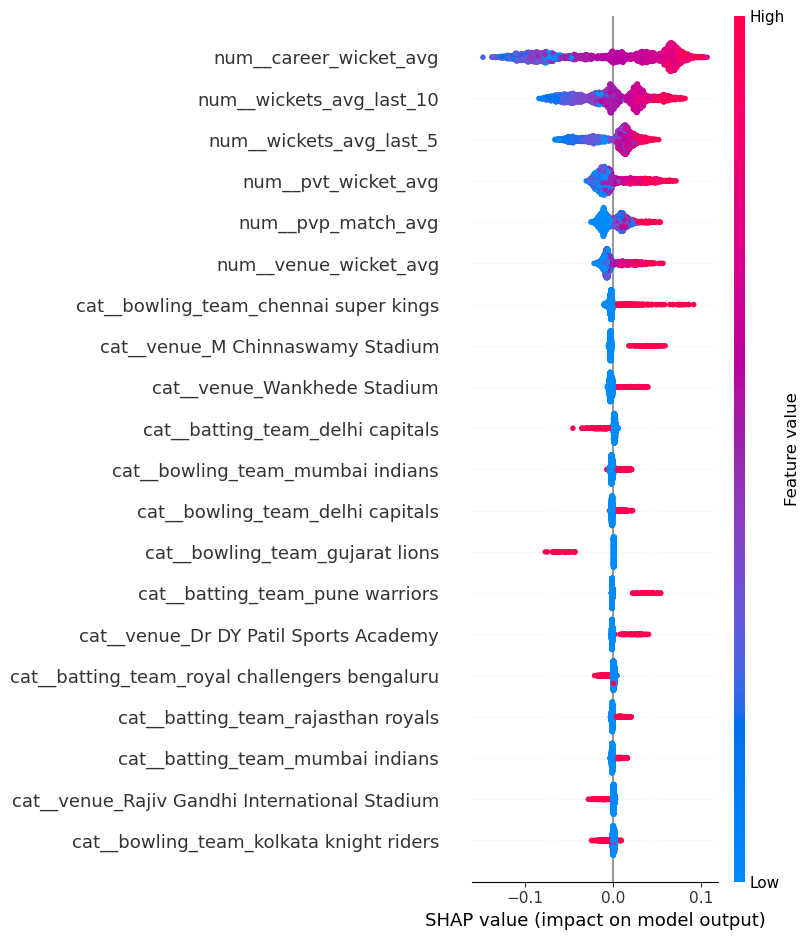

In [14]:
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values,
    X_shap_sample,
    feature_names=feature_names,
    show=True
)

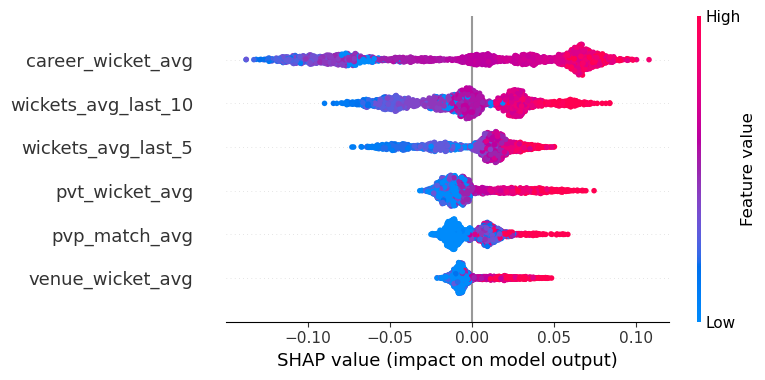

In [15]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Sample small data (avoid memory crash)
# -------------------------------
sample_size = 2000

sample_idx = np.random.choice(
    X_train_p.shape[0],
    sample_size,
    replace=False
)

X_sample = X_train_p[sample_idx]

# Convert ONLY sample to dense if sparse
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

# -------------------------------
# 2️⃣ Create SHAP explainer
# -------------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# -------------------------------
# 3️⃣ Keep ONLY numeric engineered features
# -------------------------------
feature_names = pipeline.get_feature_names_out()

numeric_indices = [
    i for i, name in enumerate(feature_names)
    if name.startswith("num__")
]

shap_values_num = shap_values[:, numeric_indices]
X_sample_num = X_sample[:, numeric_indices]

clean_feature_names = [
    feature_names[i].replace("num__", "")
    for i in numeric_indices
]

# -------------------------------
# 4️⃣ Plot Clean Global Beeswarm
# -------------------------------
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values_num,
    X_sample_num,
    feature_names=clean_feature_names,
    max_display=8
)